<h1>SM-NUMBA-SINTEL-convolved
</h1><br>


In [2]:
import numpy as np
from components.classes.NumbaSimpleMatcher import Wrapper as m
from components.classes.SimpleProgressBar import SimpleProgressBar

from components.non_oo_entities import utils as u
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc
from components.classes.CSVExperimentLogger2 import CSVExperimentLogger2 as l
from components.classes.Metrix import Metrix as me
from components.classes.SintelReader import SintelReader
from components.non_oo_entities import plot_utils as plu

import math
import time
import glob
import importlib

##Configuring and testing data generator

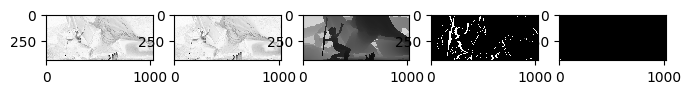

Directory './optimization/final//numba_pm' already exists.

In [3]:
ROOT_DATA_SRC = "./optimization/final/"
LOG_DIRECTORY = ROOT_DATA_SRC+"/numba_pm/"
CSV_FILE_NAME =  "sm_mixed_scanlines_demo_convolutions.csv"
CSV_FILE_PATH = os.path.join(LOG_DIRECTORY, CSV_FILE_NAME)


path = "./datasets/sintel/training"
reader = SintelReader(rootPath=path)
#reader.print_available_scenes()
reader.set_selected_scene('cave_4')
loaded_imgs = reader.get_selected_scene_next_files()
SintelReader.plot_images_to_compare(loaded_imgs)

log = l(file_path = CSV_FILE_PATH)
progress_bar = SimpleProgressBar.get_instance()

importlib.reload(u)

spec_dict = dict({})

spec_dict["is_parallel"] = "True"
spec_dict["img_name"] = "sintel_sm_convolved_230_512"
spec_dict["alg_type"] =  "sm_numba_matcher_stacked"
spec_dict["is_img_preprocessed"] = "yes"
spec_dict["convolution_filters"] = "see-filter-strategy"
spec_dict["filter_strategy"] = "-"
spec_dict["matching_mode"] = non_occ =  "occlusions_added_to_the_groundtruth"
spec_dict["matrix_init_mode"] = 2



ORIGINAL_IMG_DIM = loaded_imgs[0].shape
STARTING_ROW_FOR_SLICES = 0
ROW_HEIGHT_PER_SLICE = 40
NUMBER_OF_COLUMNS = int(ORIGINAL_IMG_DIM[1]/2)
SCENES = reader.get_available_scenes()


SLICE_DIM = [ROW_HEIGHT_PER_SLICE, NUMBER_OF_COLUMNS]


##Matcher visual and metrical testing

> Indented block



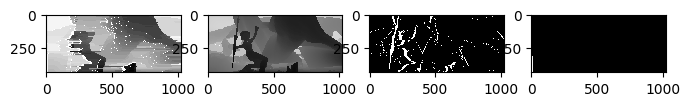

[148.31887901376146, 24860.13216743119, 105352.52274150819]


In [4]:
m_score, gap_score, egap_score = 60, -20, -1
matcher = m(m_score, gap_score, egap_score)
    
matcher.set_images(loaded_imgs[1], loaded_imgs[0])  
matcher.configure_instance()      
x,raw_disp_map = matcher.run_pipeline()

SintelReader.plot_images_to_compare([raw_disp_map, loaded_imgs[2], loaded_imgs[3], loaded_imgs[4]])

disp_modified = SintelReader.add_masks_to_raw_disparity(loaded_imgs[2],loaded_imgs[3], loaded_imgs[4])
ABS_ERR = me.avgerr(raw_disp_map, disp_modified)
mse = me.mse(raw_disp_map, disp_modified)
euclid = me.eucledian_distance(raw_disp_map, disp_modified)

print([ABS_ERR, mse, euclid])

Number of processors:  36


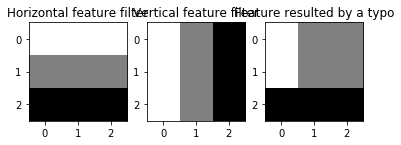

In [5]:
#demonstrating the effects of convolutions
from components.classes import SimpleConvolution as SC

convolver = SC.getOne()
im2 = loaded_imgs[0]
im6 = loaded_imgs[1]

im2_blurred = convolver.convolve(im2)
im6_blurred = convolver.convolve(im6)

u.getHorizontalFeatureFilter(convolver)

horizontal_feature = convolver.filter

im2_h = convolver.convolve(im2)
im6_h = convolver.convolve(im6)

u.getVerticalFeatureFilter(convolver)

vertical_feature = convolver.filter

im2_v = convolver.convolve(im2)
im6_v = convolver.convolve(im6)

u.getFilterByTypo(convolver)

typo_filter = convolver.filter

im2_t = convolver.convolve(im2)
im6_t = convolver.convolve(im6)


im2_features_added = im2+im2+im2_h+im2_t
im6_features_added = im6+im6+im6_h+im6_t


im2s = [im2, im2_blurred,  im2_h, im2_v, im2_t, im2_features_added]
im6s = [im6, im6_blurred, im6_h, im6_v, im6_t, im6_features_added]

ax = plt.subplot(131)
ax.set_title("Horizontal feature filter")
plt.imshow(horizontal_feature, "gray")
ax = plt.subplot(132)
ax.set_title("Vertical feature filter")
plt.imshow(vertical_feature, "gray")
ax = plt.subplot(133)

ax.set_title("Feature resulted by a typo")
plt.imshow(typo_filter, "gray")

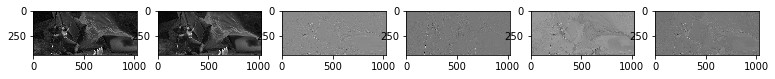

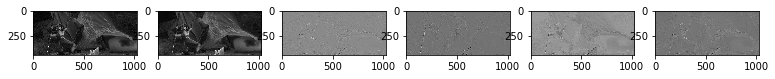

In [6]:
from components.non_oo_entities import plot_utils as plu
plu.plotNImages(im2s)
plu.plotNImages(im6s) 

##Initialising loop parameters

In [8]:
main_temp = []
processed_img_pairs = []
for i in range(len(SCENES)):
  reader.set_selected_scene(SCENES[i])
  temp = reader.get_selected_scene_next_sliced(SLICE_DIM, starting_row = 0)
  temp = np.array(temp)
  main_temp.append(temp)
  temp_imgs = u.apply_demo_filters(temp)
  processed_img_pairs.append(temp_imgs)    
    
stacked_imgs = np.hstack(main_temp)
stacked_processed_img_pairs_raw = np.array(processed_img_pairs)
print(stacked_processed_img_pairs_raw.shape)
stacked_processed_img_pairs = np.concatenate(stacked_processed_img_pairs_raw, axis=2)
print(stacked_processed_img_pairs.shape)

gt = reader.add_masks_to_raw_disparity(stacked_imgs[2], stacked_imgs[3], stacked_imgs[4])


(23, 2, 6, 40, 512)
(2, 6, 920, 512)


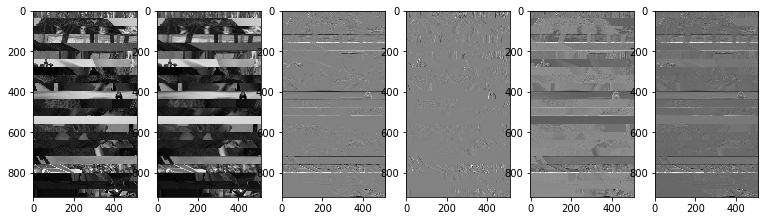

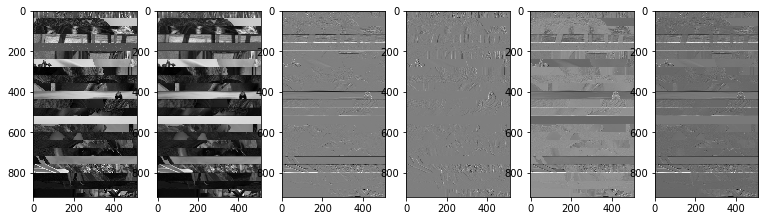

In [9]:
plu.plotNImages(stacked_processed_img_pairs[0])
plu.plotNImages(stacked_processed_img_pairs[1])

In [10]:
test_matcher = m(60, -20, -1)
test_matcher.configure_instance()
test_matcher.set_images(stacked_processed_img_pairs[1 ,5], stacked_processed_img_pairs[0,5])
%time x, disp = test_matcher.run_pipeline()


CPU times: user 30min 18s, sys: 2.98 s, total: 30min 21s
Wall time: 51.9 s


(920, 512)
(920, 512)
67.15909901494565


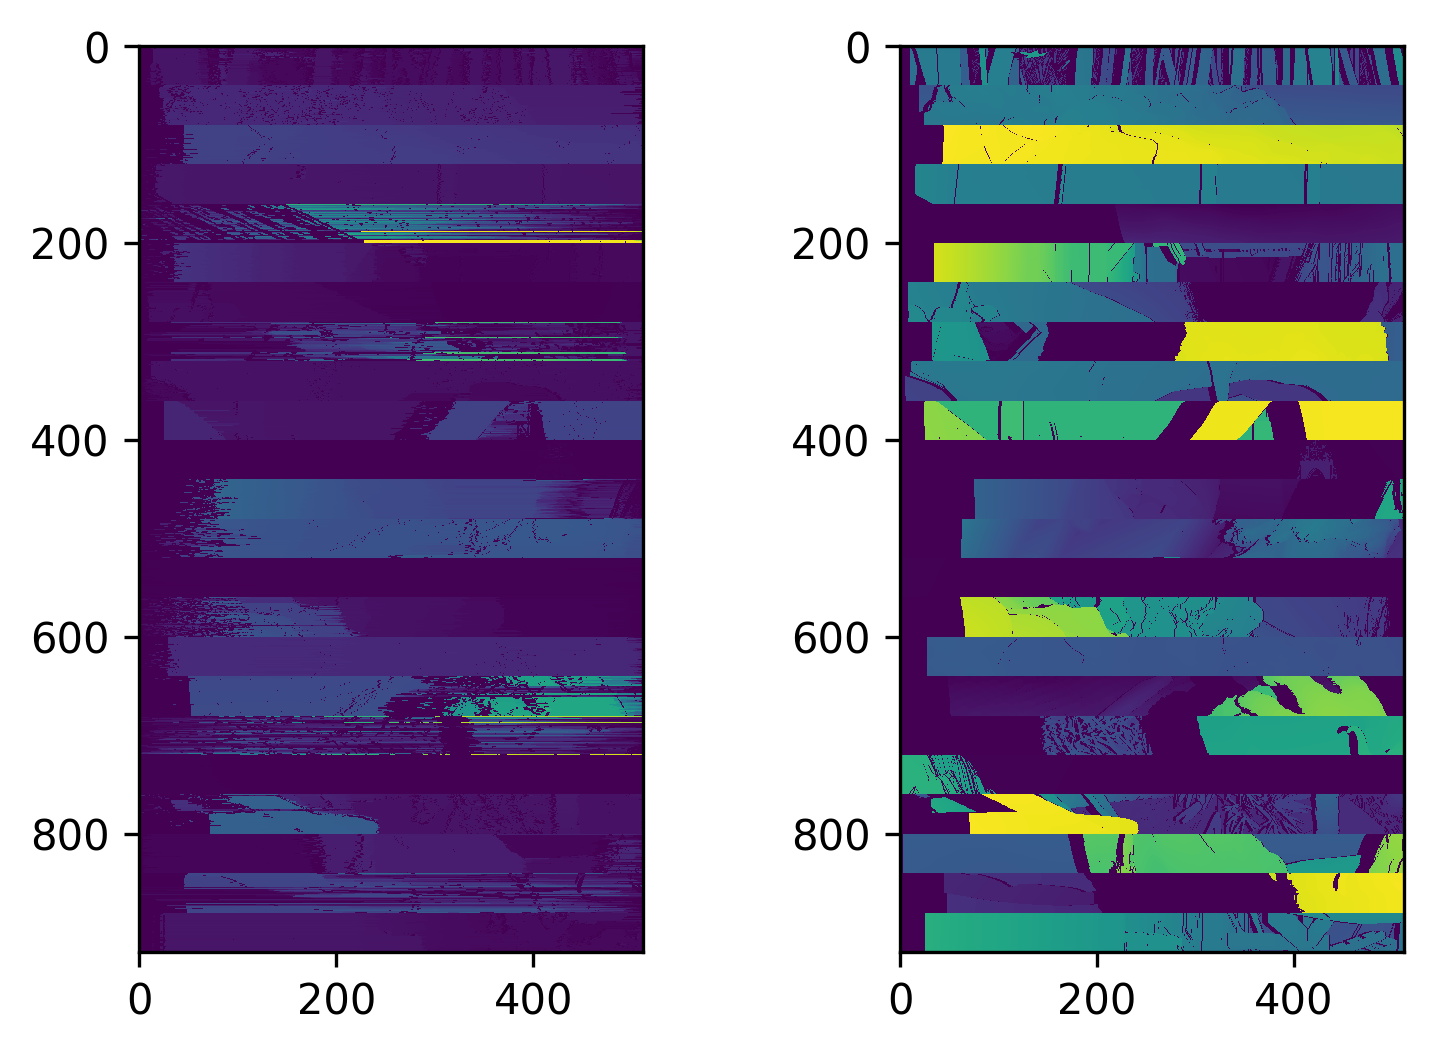

In [11]:
gt = reader.add_masks_to_raw_disparity(stacked_imgs[2], stacked_imgs[3], stacked_imgs[4])
print(disp.shape)
print(gt.shape)
%matplotlib inline
plt.figure(dpi=300)
plt.subplot(121)
plt.imshow(disp)
plt.subplot(122)
plt.imshow(gt)
print(me.avgerr(disp, gt))

In [12]:
import pandas as pd
#todo select the appropriate file
temp_path = "./optimization/final/numba_legacy/legacy_mixed_lines.csv"
results_data_frame = pd.read_csv(temp_path)
results_data_frame.columns = [str.strip(col) for col in results_data_frame.columns]

results_data_frame.describe()


,match,gap,egap,matrix_init_mode,runtime,euclid_distance,mse,ABS_ERR
count,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000
mean,75.000000,-45.000000,-40.000000,2.0,20.167556,40351.744597,13859.730032,94.086499
std,46.110824,28.730977,31.631764,0.0,0.244460,1964.868976,1411.572178,5.112703
min,0.000000,-90.000000,-90.000000,2.0,19.054626,37361.034515,11853.319463,85.450280
25%,37.500000,-70.000000,-70.000000,2.0,20.104191,39448.640176,13214.972928,92.250425
50%,75.000000,-45.000000,-40.000000,2.0,20.180402,40127.836761,13673.940931,93.515065
75%,112.500000,-20.000000,-10.000000,2.0,20.239465,40646.372078,14029.615869,94.600760
max,150.000000,0.000000,10.000000,2.0,22.554628,50147.851499,21355.358441,115.212458


In [13]:
top5_config = []

selected_metric = "ABS_ERR"
res = results_data_frame.sort_values(by=selected_metric).head(10)
res = res[["match", "gap", "egap", selected_metric]].values
top5_config.append(res)

selected_metric = "mse"
res = results_data_frame.sort_values(by=selected_metric).head(10)
res = res[["match", "gap", "egap", selected_metric]].values
top5_config.append(res)

selected_metric = "euclid_distance"
res = results_data_frame.sort_values(by=selected_metric).head(10)
res = res[["match", "gap", "egap", selected_metric]].values
top5_config.append(res)
top5_config.append([60, -20, -1, 0])
stacked = np.vstack(top5_config)
print(stacked.shape[0])
print("Please enter the estimated runtime per images in seconds below:")
runtime_multiplyer = input()

31
Please enter the estimated runtime per images in seconds below:


 38.8


In [14]:
number_of_iterations = 16

number_of_iterations =number_of_iterations  * stacked_processed_img_pairs.shape[1]
est_runtime = int(number_of_iterations) * float(runtime_multiplyer)

print("The number of iterations based on the params: {0}".format(round(number_of_iterations)))
print("The amount of time (s) needed to perform the parameter search: {0}".format(est_runtime))
print("The amount of time (h) needed to perform the parameter search: {0}".format(est_runtime/3600))

The number of iterations based on the params: 96
The amount of time (s) needed to perform the parameter search: 3724.7999999999997
The amount of time (h) needed to perform the parameter search: 1.0346666666666666


##Running the optimisation

In [15]:
progress_counter = 1
start_time = time.time()

im1s, im2s = stacked_processed_img_pairs[0], stacked_processed_img_pairs[1]
#(2, 6, 920, 512)
for best_params in stacked:
    cv_index = 0
    for im1, im2 in zip(im1s, im2s):

      spec_dict["matrix_init_mode"] = 2

      match = spec_dict["match"] = best_params[0]
      gap = spec_dict["gap"] = best_params[1]
      egap = spec_dict["egap"] = best_params[2]

      matcher = m(match, gap, egap)

      matcher.set_images(im2, im1)
      matcher.configure_instance()   
    
      tic=time.time()
        
      x,raw_disp_map = matcher.run_pipeline()
      toc = time.time()
      spec_dict["runtime"] = toc-tic
      spec_dict["filter_strategy"] = "filter: "+str(cv_index)
      spec_dict["mse"] = me.mse(raw_disp_map, gt)
      spec_dict["euclid_distance"] =me.eucledian_distance(raw_disp_map, gt)
      spec_dict["ABS_ERR"] = me.avgerr(raw_disp_map, gt, print=False)
      progress_bar.progress_bar(progress_counter, number_of_iterations, header= "Parameter search progress: ", progress_bar_steps=100)
      progress_counter+=1
      log.append_new_sm_results(spec_dict)
      cv_index+=1;
    
    end_time = time.time()

Parameter search progress:  [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 193.75 % completed: 186 / 96 steps

In [16]:
print("The optimisation process taken {0} seconds or {1} hours".format((end_time-start_time), (end_time-start_time)/3600))

The optimisation process taken 9616.824477434158 seconds or 2.6713401326205997 hours
